# **Capstone Project - Weather Data Analysis and Forecasting for Different Regions in the Country**

---

### Problem Statement
#### 1. Collect weather data from [OpenWeatherMap API](https://openweathermap.org/) and [Weather API](https://www.weatherapi.com/) for different regions in Kenya
#### 2. Store it in a database of your choice (relational or non-relational)
#### 3. Analyze weather patterns using Python.

##### The goal is to derive insights into temperature trends, rainfall patterns, and other weather variables across different regions.

##### These insights can help users make informed decisions for weather-sensitive activities, such as agriculture, tourism, and outdoor events.

---

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import time
import requests
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [11]:

#? load environmental variables from a dotenv file
load_dotenv()
api_key=os.getenv('API_KEY') #? get API key
database_url=os.getenv('DATABASE_URL') #? get database URL
db_url=f'postgresql+psycopg2://{database_url}' #? format database connection string

#? load county data from JSON file and extract the city names
with open('data/counties.json','r') as f:
    counties=json.load(f)

#? list of cities for data collection
cities=[county['name'] for county in counties]

#? set unit for temperature in Celsius
unit='metric' 

base_url='https://api.openweathermap.org/data/2.5/weather' #? base URL for OpenWeatherMap API

def get_weather_openweathermap(city):
    url=f'{base_url}?q={city},KE&appid={api_key}&units={unit}'
    response=requests.get(url)

    if response.status_code==200:
        data=response.json()
        return data
    else:
        print(f'Failed to get data for {city}:{response.status_code}')
        return None

def collect_and_store_weather_data(cities):
    weather_data_list=[] #? list to store data for each city
    
    for city in cities:
        data=get_weather_openweathermap(city) #? fetch weather data for each city
        if data:
            #? extract relevant weather information
            weather_info={
                'city':data['name'],
                'country':data['sys']['country'],
                'latitude':data['coord']['lat'],
                'longitude':data['coord']['lon'],
                'temperature':data['main']['temp'],
                'humidity':data['main']['humidity'],
                'pressure':data['main']['pressure'],
                'wind_speed':data['wind']['speed'],
                'visibility':data['visibility'],
                'rain':data['rain']['1h'] if 'rain' in data and '1h' in data['rain'] else 0,
                'clouds':data['clouds']['all'],
                'sunrise':pd.to_datetime(data['sys']['sunrise'],unit='s',utc=True),
                'sunset':pd.to_datetime(data['sys']['sunset'],unit='s',utc=True),
                'weather_condition':data['weather'][0]['main'],
                'weather_description':data['weather'][0]['description'],
                'datetime':pd.to_datetime(data['dt'],unit='s',utc=True)
            }

            weather_data_list.append(weather_info) #? add weather information to the list

        time.sleep(1) #? wait for 1 second before fetching the next city(API rate limit)


    if weather_data_list:
        df=pd.DataFrame(weather_data_list) #? convert list to dataframe

        engine=create_engine(db_url) #? create database engine

        #? store weather data in the database
        df.to_sql('weather_data',engine,if_exists='append',index=False)
        print('Data stored successfully.')

        #? store weather data in a CSV file
        csv_file='weather_data.csv'
        if not os.path.exists(csv_file):
            #? write with headers if it's a new file
            df.to_csv(csv_file, mode='w', header=True, index=False)
        else:
             #? append without headers if file exists
             df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        print('No data to store.')

collect_and_store_weather_data(cities)

Failed to get data for Tana River:404
Failed to get data for Taita-Taveta:404
Failed to get data for Tharaka-Nithi:404
Failed to get data for Nyandarua:404
Failed to get data for Kirinyaga:404
Failed to get data for Turkana:404
Failed to get data for West Pokot:404
Failed to get data for Samburu:404
Failed to get data for Trans-Nzoia:404
Failed to get data for Uasin Gishu:404
Failed to get data for Elgeyo-Marakwet:404
Failed to get data for Laikipia:404
Failed to get data for Busia:404
Data stored successfully.


In [18]:
df=pd.read_csv('data/weather_data.csv',parse_dates=['datetime','sunrise','sunset'],date_parser=pd.to_datetime)
df.shape

C:\Users\user\AppData\Local\Temp\ipykernel_5760\3594628356.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df=pd.read_csv('data/weather_data.csv',parse_dates=['datetime','sunrise','sunset'],date_parser=pd.to_datetime)


(34, 16)

In [19]:
df.head()

,city,country,latitude,longitude,temperature,humidity,pressure,wind_speed,visibility,rain,clouds,sunrise,sunset,weather_condition,weather_description,datetime
0,Mombasa,KE,-4.0547,39.6636,24.92,86,1016,5.91,10000,0.22,2,2024-10-11 03:02:28+00:00,2024-10-11 15:13:15+00:00,Rain,light rain,2024-10-11 17:00:37+00:00
1,Kwale,KE,-4.1738,39.4521,21.48,89,1016,3.69,10000,0.00,2,2024-10-11 03:03:16+00:00,2024-10-11 15:14:10+00:00,Clear,clear sky,2024-10-11 17:01:10+00:00
2,Kilifi,KE,-3.6305,39.8499,25.07,86,1015,6.49,10000,0.00,1,2024-10-11 03:01:57+00:00,2024-10-11 15:12:18+00:00,Clear,clear sky,2024-10-11 17:01:12+00:00
3,Lamu,KE,-2.2717,40.9020,25.29,87,1015,6.90,10000,0.00,8,2024-10-11 02:58:25+00:00,2024-10-11 15:07:24+00:00,Clear,clear sky,2024-10-11 17:01:18+00:00
4,Garissa,KE,-0.4536,39.6401,28.62,52,1012,12.09,10000,0.00,1,2024-10-11 03:04:23+00:00,2024-10-11 15:11:32+00:00,Clear,clear sky,2024-10-11 17:01:23+00:00


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   city                 34 non-null     object             
 1   country              34 non-null     object             
 2   latitude             34 non-null     float64            
 3   longitude            34 non-null     float64            
 4   temperature          34 non-null     float64            
 5   humidity             34 non-null     int64              
 6   pressure             34 non-null     int64              
 7   wind_speed           34 non-null     float64            
 8   visibility           34 non-null     int64              
 9   rain                 34 non-null     float64            
 10  clouds               34 non-null     int64              
 11  sunrise              34 non-null     datetime64[ns, UTC]
 12  sunset               34 

In [21]:
df.dtypes

city                                object
country                             object
latitude                           float64
longitude                          float64
temperature                        float64
humidity                             int64
pressure                             int64
wind_speed                         float64
visibility                           int64
rain                               float64
clouds                               int64
sunrise                datetime64[ns, UTC]
sunset                 datetime64[ns, UTC]
weather_condition                   object
weather_description                 object
datetime               datetime64[ns, UTC]
dtype: object

In [22]:
df['weather_condition'].value_counts()

weather_condition
Clouds    20
Rain       7
Clear      7
Name: count, dtype: int64

In [23]:
df['weather_condition'].unique()

array(['Rain', 'Clear', 'Clouds'], dtype=object)

In [24]:
df['weather_description'].value_counts()

weather_description
broken clouds       11
clear sky            7
light rain           5
few clouds           4
scattered clouds     3
overcast clouds      2
moderate rain        2
Name: count, dtype: int64

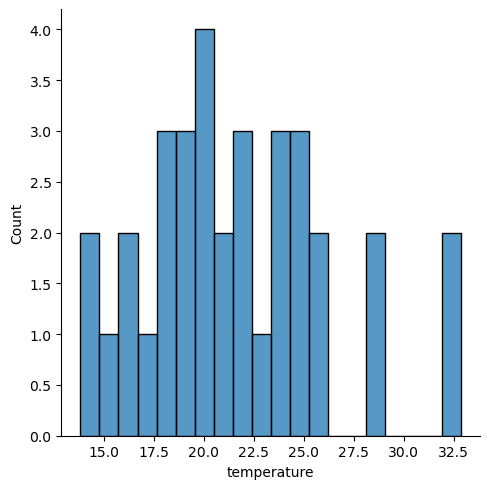

In [31]:
sns.displot(df['temperature'],bins=20)

In [28]:
df['temperature'].describe()

count    34.000000
mean     21.690294
std       4.621484
min      13.820000
25%      18.512500
50%      21.065000
75%      24.660000
max      32.870000
Name: temperature, dtype: float64